# Example 0
## Anomaly detection in artificial data with linear neuron
In this example we demonstrate the capabilities of Learning Entropy on anomaly detection of artificial signal monitored with linear neuron.  The signal is generated from 3 sinus signals with various properties and then combined together to one signal. Our signal is then from $N^{th}$ position suddenly changed. This sudden change is expected to be caught by the Learning Entropy.

A showcase for sample usage in native python and JAX are shown. Then also the evaluation times for python and JAX accelerated Learning Entropy are compared.

In [1]:
# Import required libs
import sys
import time

import matplotlib.pyplot as plt
import numpy as np

# Get access to root folder of the notebook
sys.path.append("..")

# Pythonic AISLE
from src.aisle import aisle as py_aisle
from src.aisle import aisle_window as py_aisle_window

# JAX accelerated AISLE
from src.aisle_jax import aisle as jax_aisle
from src.aisle_jax import aisle_window as jax_aisle_window

%matplotlib widget

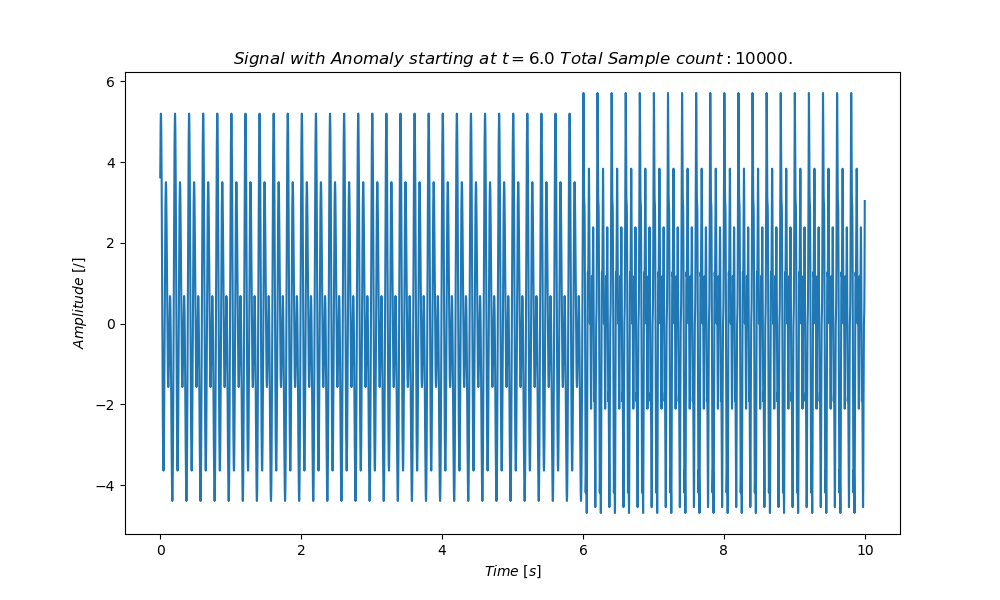

In [2]:
# Setup Constants
frequencies = [5, 10, 15]  # Frequencies in Hz for each signal
amplitudes = [1, 2, 3]  # Amplitudes for each signal
phases = [0, 1.275, 6.89]  # Phases in radians for each signal
anomaly_start = 6000  # Anomaly start position
noise_level = 0.0  # Noise level

# Anomaly parameters
anomaly_type = {"frequency": 50, "amplitude": 0.5}  # Options: 'amplitude', 'frequency', 'phase'
anomaly_index = 0  # Index for which signal to corrupt: 0 for signal1; 1 for signal2; 2 for signal3

# Time domain
t = np.arange(0, 10, 0.001)

# Generate signals
signals = [amplitudes[i] * np.sin(2 * np.pi * frequencies[i] * t + phases[i]) for i in range(3)]

# Introduce anomaly in the chosen signal from Nth position
anomaly_type_keys = list(anomaly_type.keys())
if "amplitude" in anomaly_type_keys:
    signals[anomaly_index][anomaly_start:] = anomaly_type["amplitude"] * np.sin(
        2 * np.pi * frequencies[anomaly_index] * t[anomaly_start:] + phases[anomaly_index]
    )
if "frequency" in anomaly_type_keys:
    signals[anomaly_index][anomaly_start:] = amplitudes[anomaly_index] * np.sin(
        2 * np.pi * anomaly_type["frequency"] * t[anomaly_start:] + phases[anomaly_index]
    )
if "phase" in anomaly_type_keys:
    signals[anomaly_index][anomaly_start:] = amplitudes[anomaly_index] * np.sin(
        2 * np.pi * frequencies[anomaly_index] * t[anomaly_start:] + anomaly_type["phase"]
    )

# Combine signals
combined_signal = np.sum(signals, axis=0)

# Generate and add noise
noise = np.random.normal(0, noise_level, combined_signal.shape)
data = combined_signal + noise

# Plot the combined signal with noise
plt.figure(figsize=(10, 6))
plt.plot(t, data, label="Signal")
plt.xlabel(r"$Time \ [s]$")
plt.ylabel(r"$Amplitude \ [/]$")
plt.title(
    rf"$Signal \ with \ Anomaly \ starting  \ at \ t={t[anomaly_start]} \ Total \ Sample \ count:{len(t)}.$"
)
plt.show()

In [3]:
# Prepare data for linear neural unit
N = data.shape[0]
nu = 20  # This can be set dynamically to decide the number of historical values in input vecor
prediction_horizon = 1

X = np.ones((N, 1 + nu))  # +1 for the bias term
y = np.zeros((N,))

# Generate X, y based on 'nu'
for k in range(nu, N - prediction_horizon):
    X[k, 1:] = data[k - nu : k][::-1]
    y[k] = data[k + prediction_horizon]

# Remove padding used for historical data and prediction horizon
X = X[nu:-prediction_horizon, :]
y = y[nu:-prediction_horizon]

In [4]:
# Initialize parameters
mu = 0.1  # Learning rate
epochs = 2

n_samples = X.shape[0]  # Number of samples
nx = X.shape[1]  # Input features count
print(f"The total amount of samples: {n_samples}.")
nw = nx  # For LNU, the number of weights is the same as the number of input features
w = np.random.randn(nw) / nw  # Initialize small weights
print(f"Total amount of trainable weights {nw}.")

# Holders for adaptation values
e = np.zeros(n_samples)
yn = np.zeros(n_samples)
wall = np.zeros((n_samples, nw))

# Training Linear Neural Unit
for epoch in range(epochs):
    for k in range(n_samples):
        x = X[k, :]
        yn[k] = np.dot(w, x)  # Calculate the predicted value
        e[k] = y[k] - yn[k]  # Calculate the error
        dyndw = x  # Gradient for LNU

        # Update weights
        # Uncomment the desired weight update rule

        # Pure Gradient Descent (GD)
        # dw = mu * e[k] * dyndw

        # GD with normalization
        dw = mu / (sum(x * x)) * e[k] * dyndw  # x0=1 => division by zero is avoided

        # GD with normalization and momentum
        # dw = 0.2 * mu / (sum(x * x)) * e[k] * dyndw + 0.8 * dw

        w = w + dw  # Update weights
        wall[k, :] = w  # Store weights for analysis

    epoch_error = np.mean(e**2)
    print(f"Epoch {epoch+1} Mean Squared Error: {epoch_error}")

The total amount of samples: 9979.
Total amount of trainable weights 21.
Epoch 1 Mean Squared Error: 0.07541636297537102
Epoch 2 Mean Squared Error: 0.018178012826278157


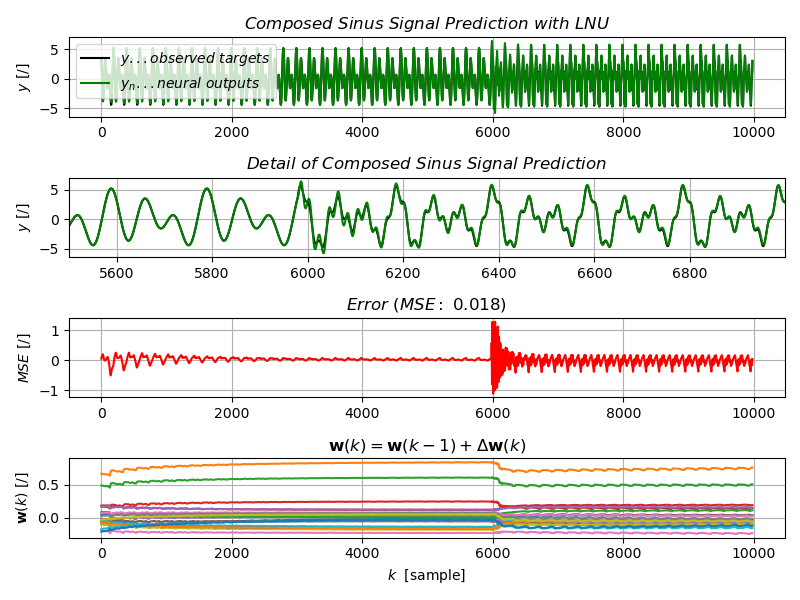

In [5]:
# Visualize model prediction, prediction detail, error and weights
error = round(epoch_error, 3)

plt.figure(figsize=(8, 6))
plt.subplots_adjust(hspace=0.5)

# Plot observed targets and neural outputs
ax1 = plt.subplot(411)
plt.title(r"$Composed \ Sinus \ Signal \ Prediction \ with \ LNU$")
plt.plot(y, "k", label=r"$y ... observed \ targets$")
plt.plot(yn, "g", label=r"$y_n ... neural \ outputs$")
plt.ylabel(r"$y \ [/]$")
plt.legend(loc="upper left")
plt.grid()

# Plot detail of noisy and neural outputs
ax2 = plt.subplot(412)
plt.title(r"$Detail \ of \ Composed \ Sinus \ Signal \ Prediction$")
sample_range = np.arange(anomaly_start - 500, anomaly_start + 1000)
plt.plot(
    sample_range, y[anomaly_start - 500 : anomaly_start + 1000], "k", label=r"$y ... observed \ targets$"
)
plt.plot(
    sample_range, yn[anomaly_start - 500 : anomaly_start + 1000], "g", label="$y_n ... neural \ outputs$"
)
plt.xlim(sample_range[0], sample_range[-1])
plt.ylabel(r"$y \ [/]$")
plt.grid()
# plt.legend()


# Plot error between observed target and neural outputs
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(e, "r", label=r"$e=y-y_n$")
plt.ylabel(r"$MSE \ [/]$")
plt.title(rf"$Error \ (MSE: \ {error})$")
# plt.legend()
plt.grid()

# Plot weights adaptation
ax4 = plt.subplot(414, sharex=ax1)
plt.plot(wall)
plt.ylabel(r"$\mathbf{w}(k) \ [/]$")
plt.title(r"$\mathbf{w}(k)=\mathbf{w}(k-1)+\Delta \mathbf{w}(k)$")
plt.grid()
plt.xlabel(r"$k$  [sample]")

plt.tight_layout()
plt.show()

In [6]:
plt.savefig("../test_local/images/0_AIXLEX_LNU.svg")

## AISLE
In this part we will demonstrate usage of Learning Entropy on anomaly detection. As explained in [[1](https://www.researchgate.net/publication/257200647_Learning_Entropy_Multiscale_Measure_for_Incremental_Learning)] and further refined in [[2](https://www.researchgate.net/publication/331041954_Learning_Entropy_as_a_Learning-Based_Information_Concept)], Learning Entropy detects an anomaly by analyzing the weight updates of an neuron. The basic concept expects that once model is trained, the changes to weight updates should remain relatively similar over observed window of weights unless there is some novelty in data, which should be detected by Learning Entropy, as model needs more _energy_ to achieve new state.

### Execution time comparisson
For comparison of pythonic approach and JAX accelerated execution we provide naive time measurement approach within this notebook. Please do note, that once the code has been executed, next unchanged executions are usually cached and therefore invalid for any comparisons. As a fair comparison serves the window implementation, which is too big to remain cached.

#### Disclaimer
Measuring execution times within Jupyter Notebook always brings certain amount of error and is supposed to be taken as indicative and not absolute. Single AISLE evaluation places JAX accelerated LE to an disadvantege, as on its initial run the code has to be compiled. Repeated runs are then already accelerated. If evaluated data are too short or weight count is low, the compilation time of JAX takes usually longer than native implementation.


#### Sources
[1] I. Bukovsky, “Learning Entropy: Multiscale Measure for Incremental Learning,” Entropy, vol. 15, no. 10, pp. 4159–4187, Sep. 2013, doi: 10.3390/e15104159.

[2] I. Bukovsky, W. Kinsner, and N. Homma, “Learning Entropy as a Learning-Based Information Concept,” Entropy, vol. 21, no. 2, p. 166, Feb. 2019, doi: 10.3390/e21020166.

### AISLE - Single value retrieval

In [7]:
# Single AISLE value retrieval
oles = (1, 2)
alphas = (10, 15)

# Python single Learning Entropy evaluation
py_aisle_time = time.time()
py_aisle_value = py_aisle(wall, alphas=alphas, oles=oles)
py_aisle_time = time.time() - py_aisle_time

# JAX accelerated single Learning Entropy evaluation
jax_aisle_time = time.time()
jax_aisle_value = jax_aisle(wall, alphas=alphas, oles=oles)
jax_aisle_time = time.time() - jax_aisle_time

msg = (
    f"Single Learning Entropy evaluation with pythonic approach took: {py_aisle_time:.6f} seconds.\n",
    f"Single Learning Entropy evaluation with JAX aproach took: {jax_aisle_time:.6f} seconds.\n\n",
    "Single init evaluation with JAX is in general slower, as on its first run it has to compile parts of",
    " the code.\nRepeated usage is recommended.\n",
    "If reporting evaluation time is 0.000.., cache has been used and invalid time results are shown",
)
msg = "".join(text for text in msg)
print(msg)

Single Learning Entropy evaluation with pythonic approach took: 0.020399 seconds.
Single Learning Entropy evaluation with JAX aproach took: 0.275727 seconds.

Single init evaluation with JAX is in general slower, as on its first run it has to compile parts of the code.
Repeated usage is recommended.
If reporting evaluation time is 0.000.., cache has been used and invalid time results are shown


### AISLE - Moving window
Pythonic implementation of AISLE

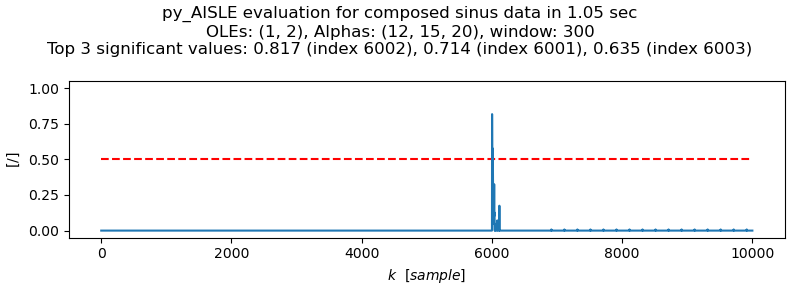

In [8]:
# AISLE setup
oles = (1, 2)  # Orders of LE
alphas = (12, 15, 20)  # Sensitivity of evaluation
window = 300  # Window evaluated for each AISLE values
threshold = 0.5  # Visual threshold (red dashed line)

# Sum, normalize and shift AISLE to correspond to original data
aisle_values = np.zeros(N)
py_aisle_time = time.time()
py_aisle_values = py_aisle_window(window, wall, alphas, oles)
py_aisle_time = time.time() - py_aisle_time
aisle_values[nu:-prediction_horizon] = np.sum(py_aisle_values, axis=1) / len(oles)

# Identify indices where aisle_values are above given threshold
indices = np.where(aisle_values > threshold)[0]
indices_values = aisle_values[indices]

# Sort these values and select top 3 significant values and their indices
sorted_indices = np.argsort(indices_values)[-3:][::-1]
top_3_indices = indices[sorted_indices]
top_3_values = indices_values[sorted_indices]

# Construct the plot title with the top three significant values
top_values_str = ", ".join([f"{aisle_values[idx]:.3f} (index {idx})" for idx in top_3_indices])
plot_title = (
    f"py_AISLE evaluation for composed sinus data in {py_aisle_time:.2f} sec\n",
    f"OLEs: {oles}, Alphas: {alphas}, window: {window}\n",
    f"Top 3 significant values: {top_values_str}",
)
plot_title = "".join(text for text in plot_title)

# Plotting
fig = plt.figure(figsize=(8, 3))
fig.suptitle(plot_title)
plt.hlines([0.5], 0, aisle_values.shape[0], colors="red", linestyles="dashed")
plt.plot(aisle_values, label="AISLE")
plt.ylabel(r"$[/]$")
plt.xlabel(r"$k~~[sample]$")
plt.ylim((-0.05, 1.05))
plt.tight_layout()
plt.show()

In [9]:
plt.savefig("../test_local/images/0_pyAISLE.svg")

### AISLE - Moving window
JAX accelerated implementation of AISLE

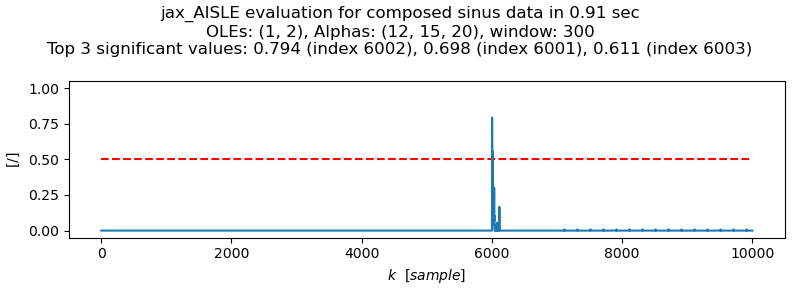

In [10]:
# Aisle setup
oles = (1, 2)  # Derivations of weights
alphas = (12, 15, 20)  # Sensitivity of evaluation
window = 300  # Window evaluated for each AISLE values
threshold = 0.5

# Sum, normalize and shift AISLE to correspond to original data
aisle_values = np.zeros(N)
jax_aisle_time = time.time()
jax_aisle_values = jax_aisle_window(window, wall, alphas, oles)
jax_aisle_time = time.time() - jax_aisle_time
aisle_values[nu:-prediction_horizon] = np.sum(jax_aisle_values, axis=1) / len(oles)


# Identify indices where aisle_values are above given threshold
indices = np.where(aisle_values > threshold)[0]
indices_values = aisle_values[indices]

# Sort these values and select top 3 significant values and their indices
sorted_indices = np.argsort(indices_values)[-3:][::-1]  # Indices of top 3 values in descending order
top_3_indices = indices[sorted_indices]
top_3_values = indices_values[sorted_indices]

# 3. Construct the plot title with the top three significant values
top_values_str = ", ".join([f"{aisle_values[idx]:.3f} (index {idx})" for idx in top_3_indices])
plot_title = (
    f"jax_AISLE evaluation for composed sinus data in {jax_aisle_time:.2f} sec\n",
    f"OLEs: {oles}, Alphas: {alphas}, window: {window}\n",
    f"Top 3 significant values: {top_values_str}",
)
plot_title = "".join(text for text in plot_title)
# Plotting
fig = plt.figure(figsize=(8, 3))
fig.suptitle(plot_title)
plt.hlines([0.5], 0, aisle_values.shape[0], colors="red", linestyles="dashed")
plt.plot(aisle_values, label="AISLE")
plt.ylabel(r"$[/]$")
plt.xlabel(r"$k~~[sample]$")
plt.ylim((-0.05, 1.05))
plt.tight_layout()
plt.show()

In [11]:
plt.savefig("../test_local/images/0_jaxAISLE.svg")

### AISLE Execution time evaluation
With the following code we verify execution speed for each of the approaches. For our task we use magic `%timeit`.

In [12]:
# AISLE with pythonic approach
%timeit -n100 -r25 py_aisle(wall, alphas=alphas, oles=oles)

3.23 ms ± 235 µs per loop (mean ± std. dev. of 25 runs, 100 loops each)


In [13]:
# AISLE with JAX accelerated approach
%timeit -n100 -r25 jax_aisle(wall, alphas=alphas, oles=oles)

1.6 ms ± 443 µs per loop (mean ± std. dev. of 25 runs, 100 loops each)


In [14]:
# AISLE window evaluation with pythonic approach
%timeit -n5 -r10 py_aisle_window(window, wall, alphas, oles)

886 ms ± 34.3 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [15]:
# AISLE window evaluation with JAX accelerated approach
%timeit -n5 -r10 jax_aisle_window(window, wall, alphas, oles)

460 ms ± 11.6 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)
